# Scalar function TV decomposition

Here our objective is to reproduce the scalar function spectral TV decomposition result. 
The example provided deals with the scalar function of the colour per face in the mesh 
and the eigen decomposition deals with the removal of the features identified in the colour 
scalar function.

In [2]:
# First we load the libraries we need 
import time

import numpy as np
import numpy.matlib
from numpy import linalg as LA
import scipy as sp
from vedo import *

import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import scipy.sparse
import scipy.sparse.linalg
import meshio
import IPython
import trimesh 
import inspect


from numpy.random import MT19937

from numpy.random import RandomState, SeedSequence

rs = RandomState(MT19937(SeedSequence(123456789)))

In [3]:
# Next we load the mesh 

#M = trimesh.load("example_meshes/octahedron.off")
M = trimesh.load("example_meshes/decompose/armadillo.obj")
V = np.array(M.vertices)
F = np.array(M.faces)

In [12]:
def dig_neighbours(M, curr_v, depth, max_depth):
    v_neighbours = [] 
    v_neighbours.append(curr_v)
    if depth == max_depth:
        return v_neighbours
    else:
        # get neighbours
        neighbours = M.vertex_neighbors[curr_v]
        for n in neighbours:
            nn = dig_neighbours(M, n, depth+1, max_depth)
            v_neighbours.extend(nn)
        return v_neighbours
        
        

def blotching(M, VERTS, blotch_num=3, min_degrees=1, max_degrees=5):
    # Create a colour scheme that adds blotches of colour onto a mesh 
    dim_v = VERTS.shape[0]
    vertices = np.random.randint(0, dim_v, size=(blotch_num, 1))
    colour_place_holder = np.ones_like(VERTS) * 255
    indicator_signal = np.zeros((dim_v, 1))
    for v in vertices: 
        v_targets = []
        v_targets.append(v)
        # generate a random colour 
        rnd_colour = np.random.randint(0, 255, size=(1, 3))
        # pick a degree of neighbours 
        degree_neighbourhood = np.random.randint(min_degrees, max_degrees)
        v_targets.extend(dig_neighbours(M, int(v), 1, degree_neighbourhood))
        #rnd_colour = np.matlib.repmat(rnd_colour, len(v_targets), 1)
        for target in v_targets:
            colour_place_holder[target, :] = rnd_colour
            indicator_signal[target] = 1
    return colour_place_holder, indicator_signal                     
        
        
        

[C, I] = blotching(M, V, 10)
#n = dig_neighbours(M, 15, 1, 4)

In [237]:
colours =  np.array([[255, 255, 255], \
                     [255, 255, 255], \
                     [255, 255, 255], \
                     [255,   0, 255], \
                     [255,   0,   0], \
                     [255,   0, 255]])
func = np.array([0, 0, 0, 1, 0, 0])

#show_mesh_with_colours(M, func)
#M.visual.vertex_colors = trimesh.visual.random_color()
M.visual.vertex_colors = C
trimesh.Scene(M).show()

In [6]:

def normest(A):
    """
    oli's attempt at normest in matlab
    square root of largest singular value of A?!?
    https://en.wikipedia.org/wiki/Matrix_norm
    """
    [e] = scipy.sparse.linalg.svds(A, k=1, return_singular_vectors=False)
    return e

def normalize(v):
    """
    normalize rows of vectors
    """
    return v / np.linalg.norm(v, axis=1)[:, np.newaxis]


def edges(f, n):
    """
    build an adjacency matrix, return edges in only one direction (upper triangular)
    """
    A = sp.sparse.triu(adjacency(f, n))
    ei, ej = A.nonzero()
    ed = np.vstack([ei, ej]).T
    # sort for consistency
    return np.sort(ed, axis=0)


def adjacency(f, n):
    """
    build a sparse adjacency matrix from faces in coordinate format.
    faces have some redundancy which we use a bitmask to filter.
    """
    A = sp.sparse.dok_matrix((n, n), dtype=bool)
    i, j, k = f.T
    A[i, j] = True
    A[j, k] = True
    A[k, i] = True
    A = A.tocsr()
    A = A + A.T
    return A


def face_normals(v, f):
    """
    compute normals of faces f
    """
    i, j, k = f.T
    a, b, c = v[i], v[j], v[k]
    
    # Compute edges, ensuring correct winding order
    ei = b - c
    ek = a - b

    # Compute the face normals
    n = np.cross(ek, ei, axis=1)

    return normalize(n)


def triangle_area(v, f):
    """
    compute triangle areas
    """
    i, j, k = f.T
    a, b, c = v[i], v[j], v[k]

    ac = c - a
    bc = c - b

    return np.linalg.norm(np.cross(ac, bc, axis=1), axis=1) / 2


def vertex_area(v, f):
    """
    compute total area about vertices
    3.59ms for 281,724 faces, not bad son
    """
    n = len(v)
    A = np.zeros((3, len(f)))

    area = triangle_area(v, f)

    # set internal angles at vertex location in face array
    # using indexes that have duplicate values to increment doesn't work
    A[0] = area
    A[1] = area
    A[2] = area

    # some esoteric numpy for summing at duplicated indices
    # coo matrices are also an option
    data = A.ravel()
    cols = f.T.ravel()

    M = np.zeros(n)
    np.add.at(M, cols, data)

    return sp.sparse.diags(M)


def barycentric_mass(v, f):
    return vertex_area(v, f) / 3



def div(v, f):
    G = grad(v, f)
    A = barycentric_mass(v, f)
    area = triangle_area(v, f)
    TA = scipy.sparse.diags(np.tile(area, 3))
    D = -sp.sparse.diags(1 / A.diagonal()) @ G.T @ TA
    return D


def grad(v, f):    
    # G_F is a diagonal matrix with the areas of the faces along the diagonal, repeated three times
    area = triangle_area(v, f)

    # Preprocess by computing 1/(2*G)
    G_F = scipy.sparse.diags(1 / np.tile(2 * area, 3))

    # To build E:
    # Get the edges opposite each vertex
    # Vectors should form a closed chain and sum to zero in a counterclockwise direction
    i, j, k = f.T
    a, b, c = v[i], v[j], v[k]

    ei = b - c
    ej = c - a
    ek = a - b

    # Compute the face normals
    n = normalize(np.cross(ek, ei, axis=1))
    
    # Rotate each edge by 90 degrees s.t. it points inward
    # Rotation is just the cross product with normal
    ei = np.cross(ei, n, axis=1)
    ej = np.cross(ej, n, axis=1)
    ek = np.cross(ek, n, axis=1)

    # Fill up the matrix E, which is 3|F| x V
    r = np.arange(len(f) * 3)
    rows = np.hstack([r, r, r])
    cols = np.hstack([i, i, i, j, j, j, k, k, k])
    data = np.hstack([
        ei[:, 0], ei[:, 1], ei[:, 2],
        ej[:, 0], ej[:, 1], ej[:, 2],
        ek[:, 0], ek[:, 1], ek[:, 2],
    ])

    E = scipy.sparse.coo_matrix((data, (rows, cols)))

    # Grad is G_F x E
    return G_F @ E

def pdhg_scalar(prox_f_star, prox_g, gradOP, divOP, u, q, gamma, sigma, tau, max_iters):
    # PDHG_ACC: implements the accelerated version of the Primal Dual Hybird
    # Gradient of: A.Chambolle, T.Pock "A first-order primal-dual algorithm for convex problems
    # with applications to imaging" (https://hal.archives-ouvertes.fr/hal-00490826/document)
    i = 1
    err = np.inf
    u_bar = u
    err_thresh=1e-5
    u_old = u
    
    while(i < max_iters and err > err_thresh):
        # update the primal and dual variables 
        q_old = q
        
        f_data = q + (sigma * (gradOP @ u_bar)) 
        q = prox_f_star(f_data, sigma)
        
        g_data = u + (tau * (divOP @ q))
        u = prox_g(g_data, tau)
        # update step parameters
        theta = 1 / np.sqrt(1 + 2 * gamma * tau)
        tau = tau * theta
        sigma = sigma / theta
        
        # extrapolate 
        u_bar = u + theta*(u - u_old)
        err = LA.norm(u - u_old)
        
        i = i + 1
        if(i % 30 == 0):
            u_old = u
    print("Iterations: ", i, " | Error: ", err)
    return u, q
    

In [124]:
# decompose Scalar function 
# Input 
# VERTS :: vertices 
# FACES :: faces
# f :: scalar value function vector [|V| x 1] 
# d :: the number of spectral components to be computed 
# alpha :: maximum diffusion time 
# alpha_scale :: a constant used to scale alpha 
def decompose_scalar(VERTS, FACES, f, d, alpha, alpha_scale):
    """
        decomposeScalar: apply the spectral TV decomposition to a scalar signal f defined on the vertices of the
        domain M, applying the algorithm 3 in the paper.
 
    """
    #thresh=1e-4; thsubh2=1e-4;
    
    # build the gradient anGd divergence operators on surfaces of TV 
    gradOP = grad(VERTS, FACES)
    divOP = div(VERTS, FACES)
    

    # get the timestep values through the norm 
    pt = normest(gradOP)
    
    # Spectral decomposition variable initializations

    dim_F = FACES.shape[0]
    dim_V = VERTS.shape[0]
    vt = np.zeros((dim_V, 1))
    v = np.zeros((dim_V, 1))
    f = np.reshape(f, (dim_V, 1))
    
    
    # initialize the primal signal u as the mean vector of f 
    u = np.ones((dim_V, 1)) * np.mean(f)
    # initialize the dual signal q 
    dim_gradOP = gradOP.shape[0]
    q = np.zeros((dim_gradOP, 1))
    
    # initialize spectral components 
    sub = np.zeros((dim_V, d))
    old_R = np.zeros((dim_V, d))
    
    # setting proximity operators 
    def prox_F_star(data, param): 
        # proximity F star operator for scalar decomposition
        temp = np.reshape(data, (-1, 3), order='F')
        temp = np.square(temp)
        temp = np.sqrt(np.sum(temp, 1))
        temp = np.matlib.repmat(temp, 1, 3)
        temp = np.maximum(np.ones_like(temp), temp)
        temp = data / temp.T
        return temp
    
    def prox_g(x, tau):
        p = tau / alpha
        y = f + v
        return (x + (p * y)) / (1 + p)
    
    max_iter = 3000; 
    
    print("STARTING THE SPECTRAL DECOMPOSITION TING 💩")
    
    for i in range(d):
        # rescale the maximum number of operations to speed up the algorithm 
        max_iter = max(max_iter*0.95, 100)
        
        #print(u.shape)
        sub[:, i] = np.squeeze(u)
        
        # compute the solution to \min_u TV(u) + 1/(2*alpha) ||u-(f+v)||^2 via
        # the PDHG algorithm
        [u,q] =  pdhg_scalar(prox_F_star, prox_g, gradOP, divOP, u, q, 0.7/alpha, 1/pt, 1/pt, max_iter)
        
        alpha_old = alpha
        
        # scale alpha  for uniform timescale
        # alpha = alpha * alpha_scale
        alpha = max(alpha-alpha_scale, 1e-6);
        v = (v + (f - u))*alpha / alpha_old; 
  
    phi = sub.copy()
    for n in range(1, phi.shape[1]):
        phi[:, n] = phi[:, n] - sub[:, n - 1]
    
    return phi

In [125]:
# Set up the hyper parameters for decomposition 
alpha = 1
n_comp = 40
nonuniform = 0
if nonuniform:
    regFact = 0.96
else:
    regFact = 1/100

# Compute the timescale WHAT IS THE TIME SCALE FOR? <- doesn't seem needed
# def decompose_scalar(VERTS, FACES, f, d, alpha, alpha_scale):
phi = decompose_scalar(V, F, I, n_comp, alpha, regFact)

STARTING THE SPECTRAL DECOMPOSITION TING 💩
Iterations:  2850  | Error:  0.0009997541904272211
Iterations:  2708  | Error:  0.004562644309118969
Iterations:  2573  | Error:  0.025374870919828717
Iterations:  2444  | Error:  0.03244454454759001
Iterations:  2322  | Error:  0.048028775948131375
Iterations:  2206  | Error:  0.08327167464592927
Iterations:  2096  | Error:  0.12006315388624758
Iterations:  1991  | Error:  0.11827870985608674
Iterations:  1891  | Error:  0.0705503243974981
Iterations:  1797  | Error:  0.13441637961943442
Iterations:  1707  | Error:  0.14654482924436005
Iterations:  1622  | Error:  0.11645103789965047
Iterations:  1541  | Error:  0.12377941237582653
Iterations:  1464  | Error:  0.04328051268348587
Iterations:  1390  | Error:  0.09180495865432554
Iterations:  1321  | Error:  0.07995575219252987
Iterations:  1255  | Error:  0.13102611499128078
Iterations:  1192  | Error:  0.12071406970436024
Iterations:  1133  | Error:  0.05873854328091358
Iterations:  1076  | E

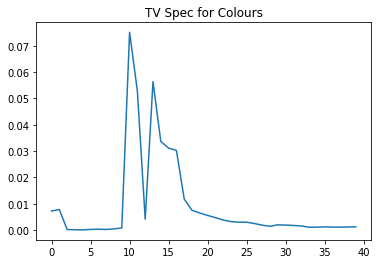

In [201]:
def Plot_TV_Spec(V, F, phi, title):
    A = barycentric_mass(V, F)
    S = np.sum(np.abs(A @ phi), 0)
    plt.plot(S)
    plt.title(title)
    plt.show()
    
Plot_TV_Spec(V, F, phi, "TV Spec for Colours")

In [280]:
def posneg_vec_normalize(v):
    min_val = np.min(v)
    new_v = (v + np.abs(min_val)) / np.linalg.norm(v)
    return new_v
    
def get_colours(v):
    dim_v = v.shape[0]
    lower_bound = np.ones_like(v) * 255
    colours = np.ones((dim_v, 3)) * 255
    colours[:, 0] = np.square(np.minimum(lower_bound, (v * 255)))
    return colours.astype(np.uint8)

def get_colours_v2(v, scale=1):
    dim_v = v.shape[0]
    v = np.reshape(v, (dim_v, 1))
    lower_bound = np.ones_like(v) * 255
    colours = np.ones((dim_v, 3)) * 255
    colours = np.minimum(lower_bound, colours * v * scale)
    colours = np.floor(colours)
    return colours.astype(np.uint8)

def get_old_colours(v, c, threshold):
    dim_v = v.shape[0]
    v_temp = np.reshape(v, (dim_v, 1))*10
    lower_bound = np.ones_like(v) * 255
    colours = np.copy(c)
    colours = np.floor(colours * v_temp)
    
    for index, v_val in enumerate(v_temp): 
        if v_val < threshold: 
            colours[index, :] = np.ones((1, 3)) * 255
    
    return colours.astype(np.uint8)


    
print("phi shape", phi.shape)


phi shape (5344, 40)


# Filtering the colour indicator signal and re-colouring the mesh

In [234]:
# recon holds the colour features that is binary? 
recon = np.sum(phi[:, 20:30], 1)
recon_normalized = posneg_vec_normalize(recon)
recon_colours = get_old_colours(recon_normalized, C, 0.5)

filtered_M = M
filtered_M.visual.vertex_colors = recon_colours
#for index, colour in enumerate(recon_colours):
#    print("v_val: ", recon_normalized[index]*10, "colour val: ", colour, "og colour: ", C[index])
trimesh.Scene(filtered_M).show()

In [198]:
# Original mesh
M.visual.vertex_colors = C
trimesh.Scene(M).show()

In [5]:
scaled_v = M.vertices * 10
scaled_M = trimesh.base.Trimesh(scaled_v, M.faces)
scaled_M.show()

## Colour decomposition using the duck from their example


In [253]:
# Load in their duck mesh

M_duck = trimesh.load("example_meshes/bob.off")
V_duck = np.array(M_duck.vertices)
F_duck = np.array(M_duck.faces)


# Add in the colours the same way as them 
[C_duck, I_duck] = blotching(M_duck, V_duck, 4, 5, 10)
M_duck.visual.vertex_colors = C_duck
trimesh.Scene(M_duck).show()

In [254]:
# Set up the hyper parameters for decomposition 
alpha = 1
n_comp = 40
nonuniform = 0
if nonuniform:
    regFact = 0.96
else:
    regFact = 1/100

# Compute the timescale WHAT IS THE TIME SCALE FOR? <- doesn't seem needed
# def decompose_scalar(VERTS, FACES, f, d, alpha, alpha_scale):
phi_duck = decompose_scalar(V_duck, F_duck, I_duck, n_comp, alpha, regFact)

STARTING THE SPECTRAL DECOMPOSITION TING 💩
Iterations:  2850  | Error:  0.030689610870523677
Iterations:  2708  | Error:  0.006464071520156625
Iterations:  2573  | Error:  0.020113731775052008
Iterations:  2444  | Error:  0.015065388144642939
Iterations:  2322  | Error:  0.014338092239984846
Iterations:  2206  | Error:  0.023821038252956516
Iterations:  2096  | Error:  0.04481902978537127
Iterations:  1991  | Error:  0.02158800534084975
Iterations:  1891  | Error:  0.0018224985494409878
Iterations:  1797  | Error:  0.03069186110637463
Iterations:  1707  | Error:  0.02117662113853095
Iterations:  1622  | Error:  0.45695054801563406
Iterations:  1541  | Error:  0.2197887833903097
Iterations:  1464  | Error:  0.07683706751606555
Iterations:  1390  | Error:  0.15263799798839955
Iterations:  1321  | Error:  0.3910031114853926
Iterations:  1255  | Error:  0.3667324953095086
Iterations:  1192  | Error:  0.5266016021180466
Iterations:  1133  | Error:  0.35422105367286205
Iterations:  1076  | E

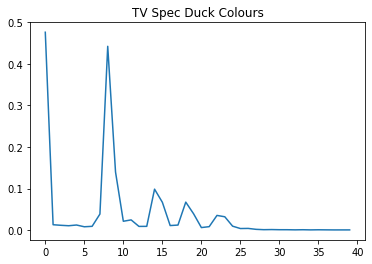

In [256]:
Plot_TV_Spec(V_duck, F_duck, phi_duck, "TV Spec Duck Colours")

In [286]:
# reconstruct duck with different colours 
recon_duck = np.sum(phi_duck[:, 16:20], 1)
recon_duck_normalized = posneg_vec_normalize(recon_duck)
recon_duck_colours = get_colours_v2(recon_duck_normalized, 20)

aug_M_duck = M_duck.copy()
aug_M_duck.visual.vertex_colors = recon_duck_colours
print(aug_M_duck.visual.vertex_colors.shape)
print(V_duck.shape)
print(recon_duck_colours)
print(recon_duck_colours.shape)

#for index, colour in enumerate(recon_duck_colours):
#    print("v_val: ", recon_duck_normalized[index], "colour val: ", colour, "og colour: ", C_duck[index])

trimesh.Scene(aug_M_duck).show()

(5344, 4)
(5344, 3)
[[56 56 56]
 [57 57 57]
 [59 59 59]
 ...
 [54 54 54]
 [57 57 57]
 [45 45 45]]
(5344, 3)


# Working with coloured meshes 


In [17]:
# Load in their duck mesh
file_name = './example_meshes/multi_color_Easter_egg_v2_L3/multi_color_Easter_egg.obj'
resolver = trimesh.visual.resolvers.FilePathResolver(file_name)
trimesh.exchange.obj.load_obj('./example_meshes/multi_color_Easter_egg_v2_L3/multi_color_Easter_egg.obj')
M_egg = kwargs.clone
V_egg = np.array(M_egg.vertices)
F_egg = np.array(M_egg.faces)


# Add in the colours the same way as them 
[C_egg, I_egg] = blotching(M_egg, V_egg, 4, 5, 10)
M_egg.visual.vertex_colors = C_egg
trimesh.Scene(M_egg).show(viewer='gl')


AttributeError: 'str' object has no attribute 'read'

# Working with x y and z coorindate scalar functions 


In [200]:
# Set up the hyper parameters for decomposition 
alpha = 1
n_comp = 40
nonuniform = 0
if nonuniform:
    regFact = 0.96
else:
    regFact = 1/100

# The scalar function we are working with are the x, y and z scalar functions 
x_func = V[:, 0]
y_func = V[:, 1]
z_func = V[:, 2]
    
# Compute the timescale WHAT IS THE TIME SCALE FOR? <- doesn't seem needed
# def decompose_scalar(VERTS, FACES, f, d, alpha, alpha_scale):
phi_x = decompose_scalar(V, F, x_func, n_comp, alpha, regFact)
phi_y = decompose_scalar(V, F, y_func, n_comp, alpha, regFact)
phi_z = decompose_scalar(V, F, _func, n_comp, alpha, regFact)

STARTING THE SPECTRAL DECOMPOSITION TING 💩
Iterations:  2850  | Error:  0.00015994159524195575
Iterations:  2708  | Error:  0.004840859546943827
Iterations:  2573  | Error:  0.06147451260697415
Iterations:  2444  | Error:  0.06554509165931593
Iterations:  2322  | Error:  0.014242627350746669
Iterations:  2206  | Error:  0.07776155841112484
Iterations:  2096  | Error:  0.11024310091285539
Iterations:  1991  | Error:  0.11393094841967553
Iterations:  1891  | Error:  0.06797423711447059
Iterations:  1797  | Error:  0.1289334052655632
Iterations:  1707  | Error:  0.12133909353208376
Iterations:  1622  | Error:  0.10977549877687529
Iterations:  1541  | Error:  0.13764416885363265
Iterations:  1464  | Error:  0.04026770152960042
Iterations:  1390  | Error:  0.07541803976335963
Iterations:  1321  | Error:  0.08455886064086882
Iterations:  1255  | Error:  0.13692195802899995
Iterations:  1192  | Error:  0.07987723105169653
Iterations:  1133  | Error:  0.030818499740214163
Iterations:  1076  | 

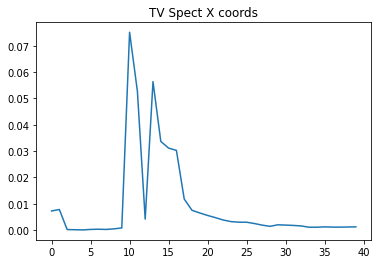

In [202]:
Plot_TV_Spec(V, F, phi_x, "TV Spect X coords")

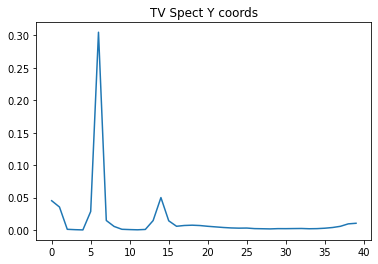

In [203]:
Plot_TV_Spec(V, F, phi_y, "TV Spect Y coords")

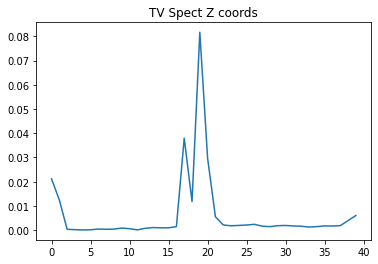

In [204]:
Plot_TV_Spec(V, F, phi_z, "TV Spect Z coords")

# Reconstruct the x, y and z filtered spectrums 


In [215]:
# Our phis are phi_x, phi_y and phi_z 
x_dim = 0 
y_dim = 1
z_dim = 2

def Recon_Coords_v1(phi, axis_coords, start_eigen, end_eigen):
    new_axis = np.copy(axis_coords)
    sum_eigens = np.zeros_like(new_axis)
    for index in range(start_eigen, end_eigen):
        sum_eigens += np.dot(new_axis, phi[:, index]) * phi[:, index]
    print("new_axis shape: ", new_axis.shape, "sum_eigens shape: ", sum_eigens.shape)
    return sum_eigens 


new_x_coords = Recon_Coords_v1(phi_x, V[:, x_dim], 0, 40)
for index, new_x in enumerate(new_x_coords):
    print("og x: ", V[index, 0], "new x: ", new_x)

aug_x_V = np.copy(V)
aug_x_V[:, x_dim] = new_x_coords
aug_x_M = M
aug_x_M.vertices = aug_x_V
trimesh.Scene(aug_x_M).show()



new_axis shape:  (361,) sum_eigens shape:  (361,)
og x:  0.168768 new x:  0.0007449275984626228
og x:  -0.001408 new x:  -0.008503188689485738
og x:  0.126185 new x:  -0.002000579049925496
og x:  0.073897 new x:  0.007701523398416847
og x:  0.25909 new x:  0.41547868564828566
og x:  0.24405 new x:  0.41229986691729303
og x:  -0.091374 new x:  -0.059572352703606064
og x:  0.058706 new x:  -0.007179587708822903
og x:  -0.07627 new x:  -0.00868706786369481
og x:  0.35253 new x:  1.2081370492324834
og x:  -0.188421 new x:  -0.1446466494382723
og x:  -0.117637 new x:  -0.1445192049148995
og x:  0.024123 new x:  -0.005725683887412393
og x:  0.083131 new x:  0.27359344042923256
og x:  -0.258844 new x:  -0.814321957423228
og x:  0.392612 new x:  1.2090582457074333
og x:  -0.148636 new x:  -0.09389066725929834
og x:  -0.060764 new x:  -0.10568328566338725
og x:  0.222372 new x:  0.4125416079667304
og x:  -0.225884 new x:  -0.14490823916361506
og x:  -0.086684 new x:  -0.010945907889067357
og x: